# Gene frequency

To analyse the differences between the age groups we can look at the frequency with which the different mutations occur in the different age groups. When looking at this, we are interested in only pathogens.

We can further expand the analysis by including annotation, which marks most genes as either oncogenes, tumor supressing genes (TSG) or both. The annotation is from the Cancer Mutation Census (CMC), which is part of the the Catalogue Of Somatic Mutations In Cancer (COSMIC).

## Setup

In [1]:
# We load the necessary packages
suppressWarnings({
library("ggplot2")
library("ggpattern")
library('dplyr')
library('ggrepel')
})


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Loading the data

In [2]:
# We load the pathogen data, only containing pathogens tested for in >=50% of patients
pathogen <- read.csv("../../derived_data/genie_v15/pathogen_filtered_50.csv")

# Alternatively, we can load the pathogens tested for in >=75% of patients
#pathogen <- read.csv("../../derived_data/genie_v15/pathogen_filtered_75.csv")

# Checking the dimensions and look of the table
dim(pathogen)
#head(pathogen)

[1] 511408     23

In [3]:
# We also load the cmc data
cmc <- read.table(file = "../../data/annotation/Census_all_driver_genes.tsv", sep="\t", quote="", header=TRUE)

# And check dimensions
dim(cmc)
# And have a look at the table
#head(cmc)

[1] 743  20

In [4]:
gene_weights <- read.csv("../../derived_data/genie_v15/gene_panel_weights_by_age_interval.csv")

gene_weights <- gene_weights[,2:6]

# And check dimensions
dim(gene_weights)
# And have a look at the table
#head(gene_weights)

[1] 35984     5

## Selection and Wrangling

After we have loaded the data, we want to select the columns we need and wrangle some of the data to fit our analysis.

In [5]:
colnames(pathogen)

table(pathogen$sample_type)

[1] "Hugo_Symbol"            "sample_id"              "SIFT_Prediction"       
 [4] "Polyphen_Prediction"    "Variant_Classification" "gnomAD_AMR_AF"         
 [7] "gnomAD_NFE_AF"          "Population"             "Pathogen"              
[10] "patient_id"             "sex"                    "race"                  
[13] "center"                 "dead"                   "age"                   
[16] "oncotree_code"          "sample_type"            "sequence_assay_ID"     
[19] "cancer_type"            "sample_type_detail"     "population"            
[22] "age_group"              "age_interval"


            Metastasis Not Applicable or Heme          Not Collected 
                160793                   9389                  31572 
               Primary            Unspecified 
                288875                  20779 

In [6]:
# From the cmc data, we only need the gene-symbol and role-in-cancer columns, so we select only those
cmc <- cmc %>% select('Gene.Symbol','Role.in.Cancer')

# Then we select the columns of interest from the pathogen data
pathogen <- pathogen %>% select('Hugo_Symbol','sample_id','patient_id','age','age_group','age_interval', 'sex','sample_type')

In [7]:
# We re-name some values in the role-in-cancer column to fit the annotation style we want
# (We basically ignore the fusion value)
cmc$Role.in.Cancer[cmc$Role.in.Cancer=='"oncogene, fusion"'] <- 'oncogene'
cmc$Role.in.Cancer[cmc$Role.in.Cancer=='"TSG, fusion"'] <- 'TSG'
cmc$Role.in.Cancer[cmc$Role.in.Cancer=='"oncogene, TSG, fusion"'] <- 'TSG/oncogene'
cmc$Role.in.Cancer[cmc$Role.in.Cancer=='"oncogene, TSG"'] <- 'TSG/oncogene'
cmc$Role.in.Cancer[cmc$Role.in.Cancer=='fusion'] <- NA
cmc$Role.in.Cancer[cmc$Role.in.Cancer==''] <- NA

In [8]:
# We create a set order to the age-intervals
age_interval_levels <- c('<20','[20-25[','[25-30[','[30-35[','[35-40[','[40-45[','[45-50[','[50-55[','[55-60[','[60-65[','[65-70[','[70-75[','[75-80[','[80-85[','[85-90[','>=90')

# And use them to make age-interval a factor in our pathogen data
pathogen$age_interval <- factor(pathogen$age_interval, levels=age_interval_levels)

In [9]:
# We rename the gene-symbol column to match the hugo-symbol column in the pathogen data
cmc <- rename(cmc, Hugo_Symbol = 'Gene.Symbol')

# This enables us to left-join the pathogen and annotation data by the Hugo-symbol columns
pathogen <- left_join(pathogen, cmc, by ='Hugo_Symbol')

In [10]:
pathogen$SEX <- NA

pathogen <- pathogen %>% mutate(SEX = case_when(sex == 'Female' ~ 'Female',
                                                sex == 'Male' ~ 'Male'))

pathogen$SAMPLE_TYPE <- NA

pathogen <- pathogen %>% mutate(SAMPLE_TYPE = case_when(sample_type == 'Primary' ~ 'Primary',
                                                        sample_type == 'Metastasis' ~ 'Metastasis'))

pathogen <- na.omit(pathogen)

In [11]:
# And then we remove duplicates from the dataset
pathogen <- pathogen[!duplicated(pathogen[,]),]

dim(pathogen)

[1] 365959     11

## Mutation frequency

After wrangling, we can calculate the mutation frequency of each gene.

In [12]:
# We use dyplr to create a new data-table containing the frequency of each mutation as a function of the total number of mutations in each age group
mut_frequency <- pathogen %>%
# We first group by age interval, and then by mutation
  group_by(age_interval, Hugo_Symbol) %>%
# We find how often that mutation occurs in that age group
  summarise(n = n()) %>%
# And find the frequency as a function of the total number of pathogens in the age group
  mutate(freq = n / sum(n))

# We re-set the age interval as a factor
mut_frequency$age_interval <- factor(mut_frequency$age_interval, levels=age_interval_levels)

`summarise()` has grouped output by 'age_interval'. You can override using the `.groups` argument.


In [13]:
head(mut_frequency)

age_interval,Hugo_Symbol,n,freq
<fct>,<chr>,<int>,<dbl>
<20,ABL1,8,0.0020325203
<20,ACVR1,19,0.0048272358
<20,AKT1,6,0.0015243902
<20,AKT2,3,0.0007621951
<20,AKT3,7,0.0017784553
<20,ALK,72,0.0182926829


In [14]:
# To see an example of what the frequency of a gene is in the different age-groups, run this little code chunck
#mut_frequency_50[which(mut_frequency_50$Hugo_Symbol=='ABL1'),]

## Plots

Plotting pathogen frequencies as a function of age.

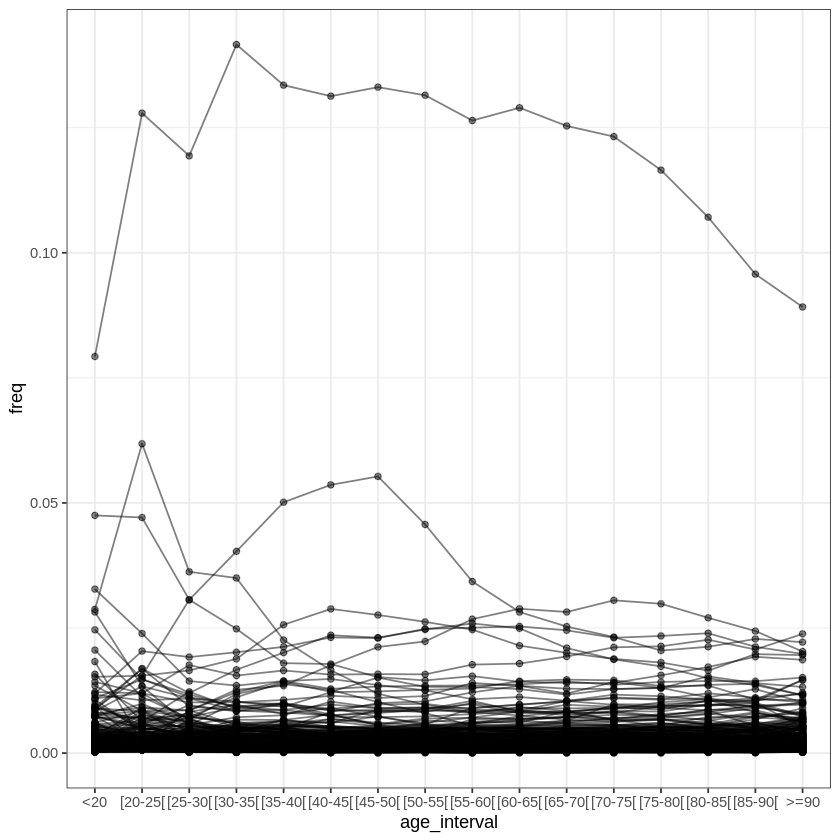

In [15]:
# We again add the annotation's role-in-cancer column
mut_frequency <- left_join(mut_frequency, cmc, by ='Hugo_Symbol')

# Simplest plot first
ggplot(mut_frequency, aes(x = age_interval, y = freq, group = Hugo_Symbol)) +
  geom_line(alpha=0.5) +
  geom_point(alpha=0.5) +
  theme_bw()

# Facet wrap by role in cancer
#ggplot(mut_frequency, aes(x = age_interval, y = freq, group = Hugo_Symbol)) +
#  geom_line(alpha=0.05) +
#  geom_point(alpha=0.05) +
#  facet_grid(rows = vars(SEX), cols = vars(SAMPLE_TYPE)) +
#  theme_bw()

In [16]:
# To only plot the genes with the highest frequency, we have to find them first

# We create an empty list for our genes
top_genes <- list()

# Loop through each age-interval
for (l in age_interval_levels){
    # Defining tmp as a subset of the data, only containing the one age-intercal
    tmp <- mut_frequency[which(mut_frequency$age_interval==l), ]
    # Saving the Hugo-symbol column as a, sorted by frequency in ascending order
    a <- tmp[order(-tmp$freq), 2]
    # And then taking the first five genes, and adding them to the list
    top_genes[length(top_genes)+1] <- a[1,]
    top_genes[length(top_genes)+1] <- a[2,]
    top_genes[length(top_genes)+1] <- a[3,]
    top_genes[length(top_genes)+1] <- a[4,]
    top_genes[length(top_genes)+1] <- a[5,]
}

# Then, to avoid duplicate genes, we save only the unique ones
top_genes <- unique(top_genes)
# And then we see how many there are
length(top_genes)

[1] 11

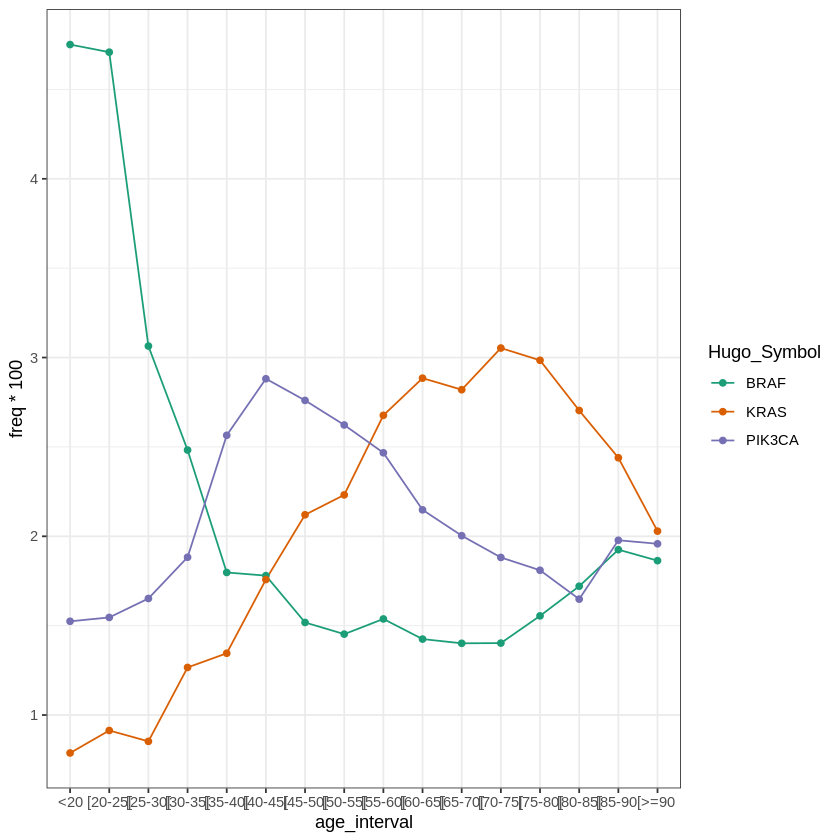

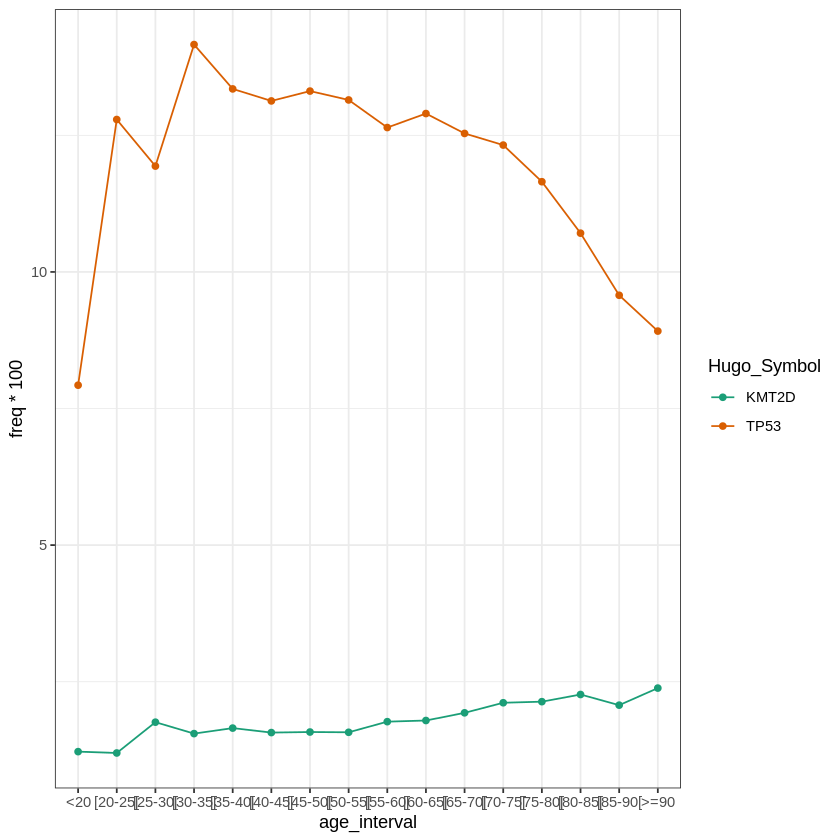

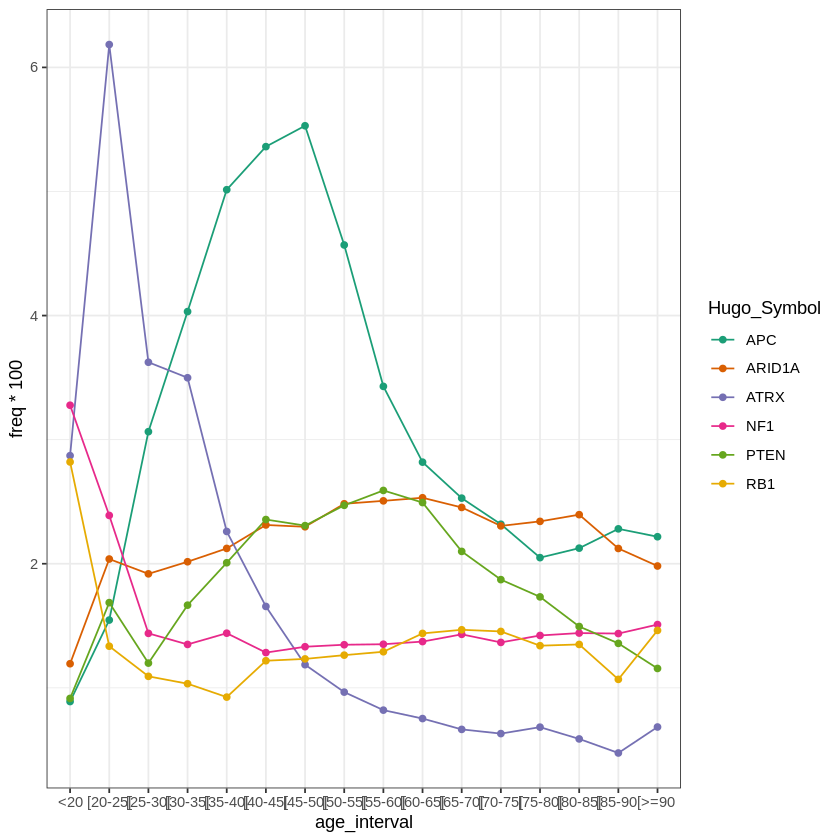

In [17]:
# And then we plot the results
# Because there are 11 individual genes, there is not a great colour-scale that can distinguish them
# We therefore start by plotting them grouped by their role in cancer

# Oncogene
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% top_genes & mut_frequency$Role.in.Cancer=='oncogene'),], 
                              aes(x = age_interval, y = freq*100, group = Hugo_Symbol, colour=Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  scale_color_brewer(palette = "Dark2") +
  theme_bw()

# TSG/Oncogene
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% top_genes & mut_frequency$Role.in.Cancer=='TSG/oncogene'),],
       aes(x = age_interval, y = freq*100, group = Hugo_Symbol, colour=Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  scale_color_brewer(palette = "Dark2") +
  theme_bw()

# TSG
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% top_genes & mut_frequency$Role.in.Cancer=='TSG'),], 
       aes(x = age_interval, y = freq*100, group = Hugo_Symbol, colour=Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  scale_color_brewer(palette = "Dark2") +
  theme_bw()

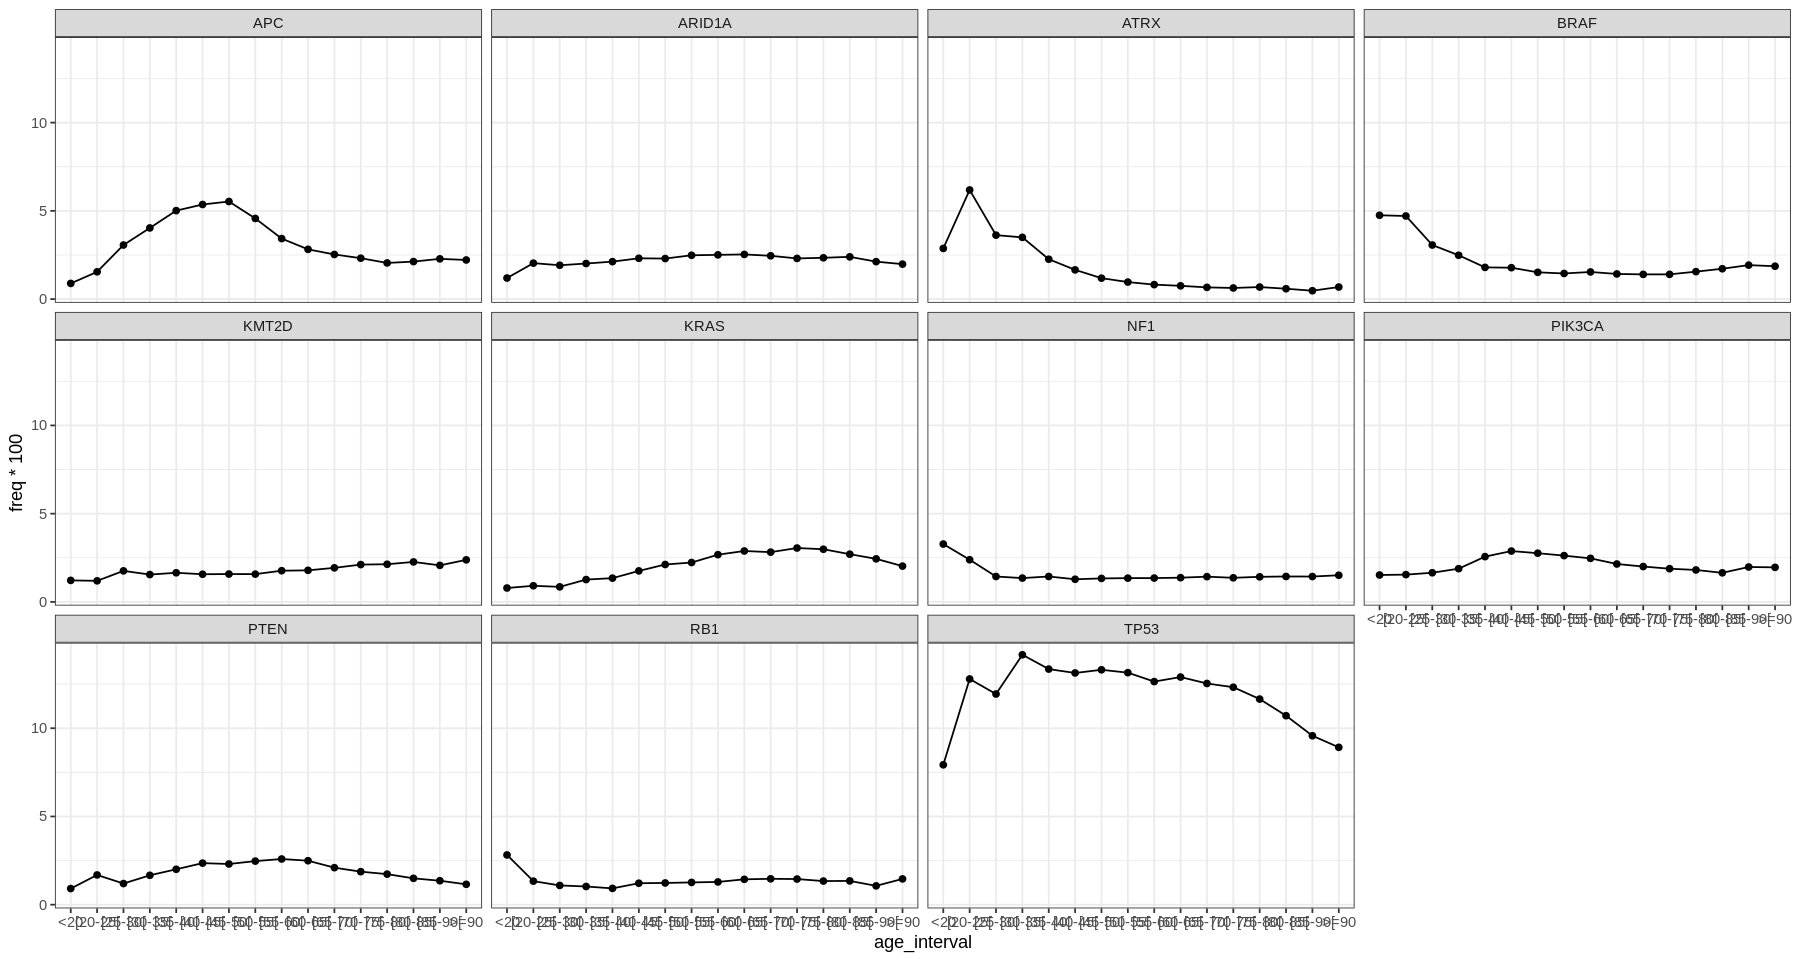

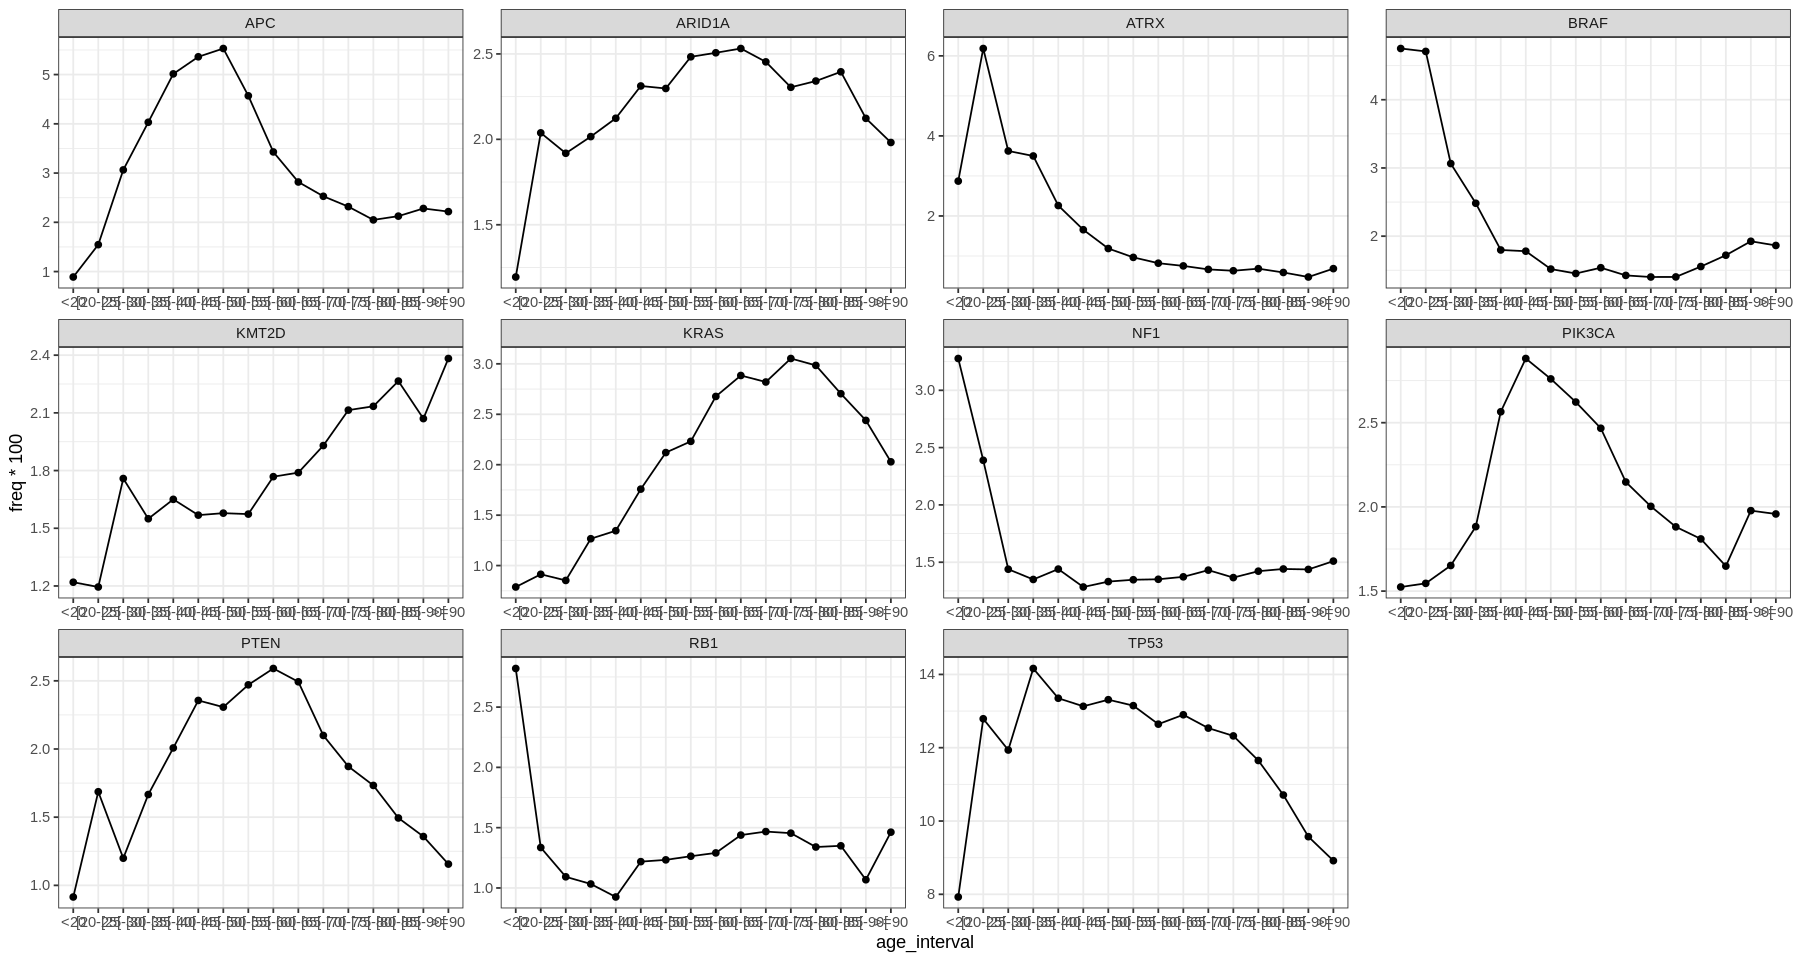

In [18]:
# We can also plot the genes individually

# But when we do this, we want slightly wider plots
options(repr.plot.width=15, repr.plot.height=8)

# Fixed scale
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% top_genes),], aes(x = age_interval, y = freq*100, group = Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  theme(legend.position = "none", axis.text.x = element_text(angle = -90)) +
  facet_wrap(~Hugo_Symbol) +
  theme_bw()

# Free scale
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% top_genes),], aes(x = age_interval, y = freq*100, group = Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  theme(legend.position = "none", axis.text.x = element_text(angle = -90)) +
  facet_wrap(~Hugo_Symbol, scales = "free") +
  theme_bw()

## Testing for significance

We want to test and see if our frequencies are significantly different from a flat distibution (bo connection to age). To do this, we do a chi-square-goodness-of-fit test for each gene.

The null-hypothesis is that the mutation frequency in each group is proportional to the number of mutations in each age group.

The alternative hypothesis is that the mutation frequency in each group is not proportional to the number of mutations in each age group.

# To meet the assumptions of the chi2-gof test, we need to re-arrange the age intervals
# Assumption: No more than 20% of the categories should have expected frequencies <5%

pathogen$age_interval2 <- '<30'
pathogen$age_interval2[pathogen$age>=30] <- '[30-45['
pathogen$age_interval2[pathogen$age>=45] <- '[45-50['
pathogen$age_interval2[pathogen$age>=50] <- '[50-55['
pathogen$age_interval2[pathogen$age>=55] <- '[55-60['
pathogen$age_interval2[pathogen$age>=60] <- '[60-65['
pathogen$age_interval2[pathogen$age>=65] <- '[65-70['
pathogen$age_interval2[pathogen$age>=70] <- '[70-75['
pathogen$age_interval2[pathogen$age>=75] <- '[75-80['
pathogen$age_interval2[pathogen$age>=80] <- '>=80'

# We create a set order to the age-intervals
age_interval_levels <- c('<30','[30-45[','[45-50[','[50-55[','[55-60[','[60-65[','[65-70[','[70-75[','[75-80[','>=80')

# And use them to make age-interval a factor in our pathogen data
pathogen$age_interval2 <- factor(pathogen$age_interval2, levels=age_interval_levels)

In [19]:
head(pathogen)

,Hugo_Symbol,sample_id,patient_id,age,age_group,age_interval,sex,sample_type,Role.in.Cancer,SEX,SAMPLE_TYPE
,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
1,KRAS,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,oncogene,Male,Primary
2,BRAF,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,oncogene,Male,Primary
3,EGFR,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,oncogene,Male,Primary
4,CTNNB1,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,oncogene,Male,Primary
5,PIK3CA,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,oncogene,Male,Primary
6,CDKN2A,GENIE-JHU-00006-00185,GENIE-JHU-00006,61,Middle Aged,[60-65[,Male,Primary,TSG,Male,Primary


In [20]:
# For our expected frequencies we use the frequency of individuals in the age intervals
# We do this by making a small datatable using dyplr

age_freq <- pathogen %>%
  group_by(age_interval, sex, sample_type) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  mutate(freq = n/sum(n))

#age_freq <- age_freq %>%
#  group_by(age_interval) %>%
#  mutate(age_n = sum(n)) %>%
#  mutate(freq = n/age_n)

# Inspecting the result
head(age_freq)

`summarise()` has grouped output by 'age_interval', 'sex'. You can override using the `.groups` argument.


age_interval,sex,sample_type,n,freq
<fct>,<chr>,<chr>,<int>,<dbl>
<20,Female,Metastasis,379,0.0010356351
<20,Female,Primary,1543,0.0042163193
<20,Male,Metastasis,453,0.0012378436
<20,Male,Primary,1561,0.0042655052
[20-25[,Female,Metastasis,169,0.0004618004
[20-25[,Female,Primary,571,0.0015602841


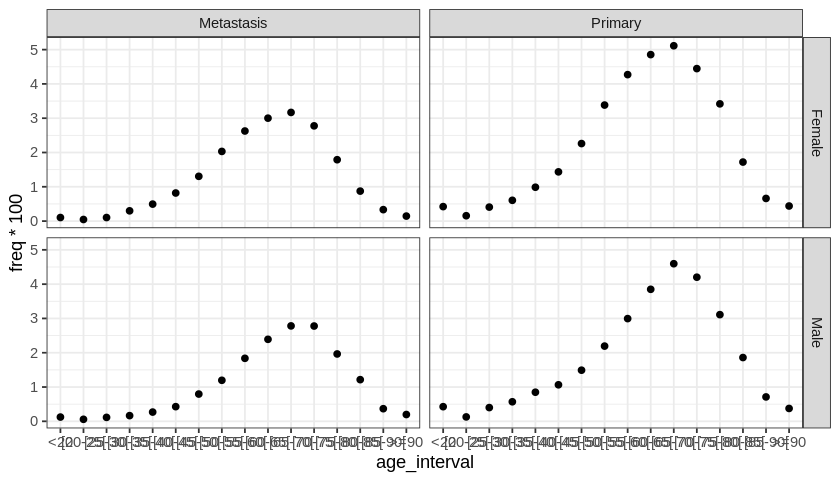

In [21]:
options(repr.plot.width=7, repr.plot.height=4)

# To check how the expected frequencies are distributed, we make a small plot
ggplot(age_freq, aes(x = age_interval, y = freq*100)) +
  geom_point() +
  facet_grid(rows = vars(sex), cols = vars(sample_type)) +
  theme_bw()

In [22]:
# We get our linear expectations from linear_expectation_full.csv, which was calculated at he end of the genie_mutation_per_Mbp notebook

linear_expectation <- read.csv("../../derived_data/linear_expectation_full.csv")

linear_expectation <- linear_expectation %>% select(-'X')

age_interval_levels <- c('<20','[20-25[','[25-30[','[30-35[','[35-40[','[40-45[','[45-50[','[50-55[','[55-60[','[60-65[','[65-70[','[70-75[','[75-80[','[80-85[','[85-90[','>=90')

# Making it a factor
linear_expectation$age_interval <- factor(linear_expectation$age_interval, levels=age_interval_levels)

head(linear_expectation)

,SEX,SAMPLE_TYPE,age_interval,mean_exp,freq
,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,Female,Metastasis,NA,0.3879895,0.1628642
2,Female,Metastasis,NA,0.4421465,0.1855974
3,Female,Metastasis,NA,0.4802601,0.2015961
4,Female,Metastasis,NA,0.5126439,0.2151897
5,Female,Metastasis,NA,0.5592488,0.2347527
6,Female,Primary,NA,0.3152943,0.1517526


In [23]:
options(repr.plot.width=7, repr.plot.height=4)

# To check how the linear expected frequencies are distributed, we make a small plot
ggplot(linear_expectation, aes(x = age_interval, y = expectation)) +
  geom_point() +
  facet_grid(rows = vars(SEX), cols = vars(SAMPLE_TYPE)) +
  theme_bw()

ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'expectation' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error

In [24]:
# Combining age-frequency and linear expectation

tmp1 <- linear_expectation %>% select('age_interval','SEX','SAMPLE_TYPE', 'expectation')
tmp1 <- rename(tmp1, sex = SEX)
tmp1 <- rename(tmp1, sample_type = SAMPLE_TYPE)

tmp2 <- age_freq %>% select('age_interval','sex','sample_type','freq')

combined <- left_join(tmp1, tmp2, by = c('age_interval','sex','sample_type'))

combined <- combined %>% mutate(product = expectation*freq)

combined <- combined %>% mutate(exp = product/sum(product))

head(combined)

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `expectation` doesn't exist.


In [ ]:
# Plotting the combined expectation
ggplot(combined, aes(x = age_interval, y = exp*100)) +
  geom_point() +
  facet_grid(rows = vars(sex), cols = vars(sample_type)) +
  theme_bw()

In [ ]:
# Then we re-calculate the mutation frequencies in each of the new age-groups as before
mut_frequency <- pathogen %>%
  group_by(age_interval2, Hugo_Symbol) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

# Inspecting the result
#head(mut_frequency)

In [ ]:
# Even if there are no mutations in a specific age-group we still need a count and frequency
# So we add these 0-rows manually

# We run through each of the new age-intervals
for (age_lvl in age_interval_levels){
    # And each unique mutation
    for (mut in unique(mut_frequency$Hugo_Symbol)){
        # We create a temporary dataframe containing only rows with our age-interval and mutation
        tmp <- mut_frequency[which(mut_frequency$age_interval2==age_lvl & mut_frequency$Hugo_Symbol==mut),]
        # If the dataframe is empty we need to add that row to our mutation frequency datatable
        if (nrow(tmp)==0){
            # We add the age
            mut_frequency[nrow(mut_frequency)+1, 1] = age_lvl
            # The mutation
            mut_frequency[nrow(mut_frequency), 2] = mut
            # The count
            mut_frequency[nrow(mut_frequency), 3] = 0
            # And the frequency
            mut_frequency[nrow(mut_frequency), 4] = 0
        }
    }
}

In [ ]:
# We check the dimensions of our updated mutation-frequency table
dim(mut_frequency)

# The number of rows need to match the product of the number of age-intervals and unique mutations
length(age_interval_levels)*length(unique(mut_frequency$Hugo_Symbol))

In [ ]:
# Create an empty data-table which will hold the chi-squared gof results
chi_squared_gof <- data.frame(matrix(ncol = 4, nrow = 0))
# We name the columns
colnames(chi_squared_gof) <- c('Hugo_Symbol', 'X_squared', 'df','p_value')

# We run through all the mutations
for (mut in unique(mut_frequency$Hugo_Symbol)){
    # Create a temporary table containing only one specific mutation
    tmp <- mut_frequency[which(mut_frequency$Hugo_Symbol==mut),]
    # Extract our observed count in each age intercal
    observed <- tmp$n
    # Perform the chi-squared test
    suppressWarnings(chi <- chisq.test(x=observed, p=expected))
    # Add the mutation and chi-squared result to our table
    chi_squared_gof[nrow(chi_squared_gof) + 1,] = c(mut,chi[1],chi[2],chi[3])
}

# Checking the results
head(chi_squared_gof)

## Plotting test results

Now we can plot our results

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

# To make labelling easier we make a new table containing only genes with a p-value under r equal to 5%
test <- chi_squared_gof[which(chi_squared_gof$p_value <= 0.05/350),]

# p-value plot
ggplot(chi_squared_gof, aes(x = Hugo_Symbol, y = -log(p_value))) +
# We colour our most fequent genes (top_genes) red and the remaining points grey
 geom_point(color = ifelse(chi_squared_gof$Hugo_Symbol %in% top_genes, "red", "grey50")) +
# We add a 5% and bon-feroni corrected 5% significance line
 geom_hline(yintercept=c(-log(0.05), -log(0.05/350)), linetype='dashed', color=c('blue', 'red')) +
# We add labels to all the genes with a p-value above 5%
 geom_text_repel(data=test, aes(label=Hugo_Symbol), max.overlaps=nrow(test))

In [ ]:
# To easily find the genes with the lowes p-values we make a new table and sort by p-value
test2 <- test %>% as.data.frame() %>% arrange((p_value))

# These plots represet the 97 genes that have p-value lower than the bon-feronni corrected 5%.

# Free scale 1
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% test2$Hugo_Symbol[1:36]),], aes(x = age_interval2, y = freq*100, group = Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  theme(legend.position = "none", axis.text.x = element_text(angle = -90)) +
  facet_wrap(~Hugo_Symbol, scales = "free") +
  theme_bw()

# Free scale 2
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% test2$Hugo_Symbol[37:72]),], aes(x = age_interval2, y = freq*100, group = Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  theme(legend.position = "none", axis.text.x = element_text(angle = -90)) +
  facet_wrap(~Hugo_Symbol, scales = "free") +
  theme_bw()

# Free scale 2
ggplot(mut_frequency[which(mut_frequency$Hugo_Symbol %in% test2$Hugo_Symbol[73:97]),], aes(x = age_interval2, y = freq*100, group = Hugo_Symbol)) +
  geom_line() +
  geom_point() +
  theme(legend.position = "none", axis.text.x = element_text(angle = -90)) +
  facet_wrap(~Hugo_Symbol, scales = "free") +
  theme_bw()

## Adding gene weights

Since there are differences in which mutations have been tested for, we need to account for this when creating the vector of expected frequencies. To do this, we use the gene_panel_weights_by_age_interval.csv file.

Before we re-do the chi-squared test, we need to check if the assumptions are met. To do this, we calculate all the expected frequency vectors, and find the number of rows with frequencies below 1 (none allowed) and the number with frequencies below 5 (maximum of 20% allowed).

In [ ]:
# Testing if the new expectations fit the assumptions of the chi-squared-gof test

# We run through each mutation
for (mut in unique(mut_frequency$Hugo_Symbol)){
    # Get the gene-frequecnies/weights of the gene in each age-groups
    gene_freq <- gene_weights[which(gene_weights$Hugo_Symbol == mut), 5]
    # we create a new vector by finding the product of the gene_frequency and expected vectors
    new_expected <- gene_freq * expected
    # We normalise by the sum of the new vector, so that the sum is always equal to one
    new_expected <- new_expected/sum(new_expected)
    # We find the number of frequencies less than or equal to 1%
    leq_one <- length(new_expected[which(new_expected <= 0.01)])
    # We find the number of frequencies less than or equal to 5%
    leq_five <- length(new_expected[which(new_expected <= 0.05)])
    # If there is even one expected frequency leq 1%
    # Or 2 or more with expected frequencies leq 5%
    # We would not meet the assumptions of the chi-squared gof test
    if (leq_one >= 1 | leq_five >= 2){
        # So if there is an unviable mutation, we need to know
        print(mut)
    }
}

# It looks like there are none! YaY! o(*￣▽￣*)o

In [ ]:
# Re-running the test

# An empty table to hold our results
chi_squared_gof2 <- data.frame(matrix(ncol = 4, nrow = 0))

# Naming the columns
colnames(chi_squared_gof2) <- c('Hugo_Symbol', 'X_squared', 'df','p_value')

# We run through all the mutations
for (mut in unique(mut_frequency$Hugo_Symbol)){
    # We get the gene-frequency from our gene-weight table
    gene_freq <- gene_weights[which(gene_weights$Hugo_Symbol == mut), 5]
    # We calculate the new expected frequencies
    new_expected <- gene_freq * expected
    # Then we addjust them, so they sum to 1
    new_expected <- new_expected/sum(new_expected)
    # We find the mutation in our frequency table
    tmp <- mut_frequency[which(mut_frequency$Hugo_Symbol==mut),]
    # And save the counts as our observation
    observed <- tmp$n
    # Then we do the chi-squared-gof test
    suppressWarnings(chi <- chisq.test(x=observed, p=new_expected))
    # And save the test results in our table
    chi_squared_gof2[nrow(chi_squared_gof2) + 1,] = c(mut,chi[1],chi[2],chi[3])
}

# Checking the results
head(chi_squared_gof2)

In [ ]:
# To make labelling easier we make a new table containing only genes with a p-value under r equal to 5%/350
test3 <- chi_squared_gof2[which(chi_squared_gof2$p_value <= 0.05/350),]

# p-value plot
ggplot(chi_squared_gof2, aes(x = Hugo_Symbol, y = -log(p_value))) +
 geom_point(color = ifelse(chi_squared_gof2$Hugo_Symbol %in% top_genes, "red", "grey50")) +
 geom_hline(yintercept=c(-log(0.05), -log(0.05/350)), linetype='dashed', color=c('blue', 'red')) +
 geom_text_repel(data=test3, aes(label=Hugo_Symbol), max.overlaps=nrow(test))

In [ ]:
# We sort our 5%/350-p-value table by p-value
test4 <- test3 %>% as.data.frame() %>% arrange((p_value))

# And check the dimensions
dim(test4)
# And look at the result
head(test4)

In [ ]:
# What genes are different between the two chi2-gof tests?
non_eq <- c(setdiff(test2$Hugo_Symbol, test4$Hugo_Symbol), setdiff(test4$Hugo_Symbol, test2$Hugo_Symbol))

# How are they different?
for (mut in non_eq){
    print(chi_squared_gof[which(chi_squared_gof$Hugo_Symbol==mut),])
    print(chi_squared_gof2[which(chi_squared_gof2$Hugo_Symbol==mut),])
}